# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

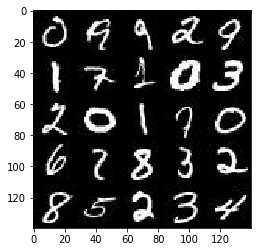

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

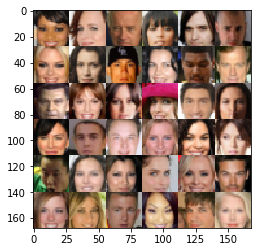

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.4751... Generator Loss: 5.6480
Epoch 1/2... Batch 20... Discriminator Loss: 0.5649... Generator Loss: 2.5510
Epoch 1/2... Batch 30... Discriminator Loss: 1.2387... Generator Loss: 8.1999
Epoch 1/2... Batch 40... Discriminator Loss: 0.7417... Generator Loss: 12.7617
Epoch 1/2... Batch 50... Discriminator Loss: 0.4205... Generator Loss: 4.3166
Epoch 1/2... Batch 60... Discriminator Loss: 0.3867... Generator Loss: 6.7115
Epoch 1/2... Batch 70... Discriminator Loss: 0.5339... Generator Loss: 2.6331
Epoch 1/2... Batch 80... Discriminator Loss: 0.7563... Generator Loss: 2.7015
Epoch 1/2... Batch 90... Discriminator Loss: 1.0783... Generator Loss: 0.9219
Epoch 1/2... Batch 100... Discriminator Loss: 1.0809... Generator Loss: 1.1436


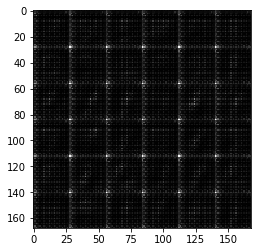

Epoch 1/2... Batch 110... Discriminator Loss: 2.0387... Generator Loss: 0.2570
Epoch 1/2... Batch 120... Discriminator Loss: 0.9224... Generator Loss: 1.3791
Epoch 1/2... Batch 130... Discriminator Loss: 1.3912... Generator Loss: 0.8230
Epoch 1/2... Batch 140... Discriminator Loss: 1.0357... Generator Loss: 1.3104
Epoch 1/2... Batch 150... Discriminator Loss: 1.5750... Generator Loss: 0.4682
Epoch 1/2... Batch 160... Discriminator Loss: 1.5860... Generator Loss: 0.6135
Epoch 1/2... Batch 170... Discriminator Loss: 1.1188... Generator Loss: 0.9814
Epoch 1/2... Batch 180... Discriminator Loss: 1.4036... Generator Loss: 0.5147
Epoch 1/2... Batch 190... Discriminator Loss: 0.9296... Generator Loss: 1.4513
Epoch 1/2... Batch 200... Discriminator Loss: 1.1790... Generator Loss: 2.0773


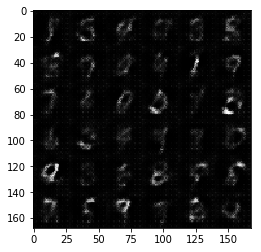

Epoch 1/2... Batch 210... Discriminator Loss: 1.1865... Generator Loss: 1.0238
Epoch 1/2... Batch 220... Discriminator Loss: 1.4435... Generator Loss: 0.7288
Epoch 1/2... Batch 230... Discriminator Loss: 1.4380... Generator Loss: 0.5734
Epoch 1/2... Batch 240... Discriminator Loss: 1.2544... Generator Loss: 1.2877
Epoch 1/2... Batch 250... Discriminator Loss: 1.2452... Generator Loss: 1.5987
Epoch 1/2... Batch 260... Discriminator Loss: 1.4709... Generator Loss: 0.7062
Epoch 1/2... Batch 270... Discriminator Loss: 1.4800... Generator Loss: 0.6113
Epoch 1/2... Batch 280... Discriminator Loss: 1.4415... Generator Loss: 1.3721
Epoch 1/2... Batch 290... Discriminator Loss: 1.2894... Generator Loss: 1.5487
Epoch 1/2... Batch 300... Discriminator Loss: 1.4323... Generator Loss: 0.5920


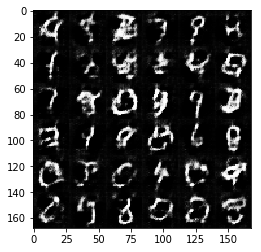

Epoch 1/2... Batch 310... Discriminator Loss: 1.2327... Generator Loss: 0.8847
Epoch 1/2... Batch 320... Discriminator Loss: 1.2148... Generator Loss: 0.9260
Epoch 1/2... Batch 330... Discriminator Loss: 1.3057... Generator Loss: 0.6283
Epoch 1/2... Batch 340... Discriminator Loss: 1.3477... Generator Loss: 0.5854
Epoch 1/2... Batch 350... Discriminator Loss: 1.2296... Generator Loss: 0.9663
Epoch 1/2... Batch 360... Discriminator Loss: 1.2409... Generator Loss: 1.6727
Epoch 1/2... Batch 370... Discriminator Loss: 1.2833... Generator Loss: 0.6041
Epoch 1/2... Batch 380... Discriminator Loss: 1.3750... Generator Loss: 0.5602
Epoch 1/2... Batch 390... Discriminator Loss: 1.4431... Generator Loss: 0.5494
Epoch 1/2... Batch 400... Discriminator Loss: 1.5197... Generator Loss: 0.4459


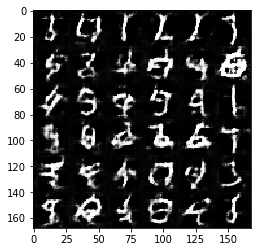

Epoch 1/2... Batch 410... Discriminator Loss: 1.2906... Generator Loss: 0.6100
Epoch 1/2... Batch 420... Discriminator Loss: 1.4378... Generator Loss: 0.4893
Epoch 1/2... Batch 430... Discriminator Loss: 1.1866... Generator Loss: 0.9390
Epoch 1/2... Batch 440... Discriminator Loss: 1.4501... Generator Loss: 0.5401
Epoch 1/2... Batch 450... Discriminator Loss: 1.1646... Generator Loss: 1.2499
Epoch 1/2... Batch 460... Discriminator Loss: 1.3741... Generator Loss: 0.6332
Epoch 1/2... Batch 470... Discriminator Loss: 1.1722... Generator Loss: 1.0493
Epoch 1/2... Batch 480... Discriminator Loss: 1.3814... Generator Loss: 0.6142
Epoch 1/2... Batch 490... Discriminator Loss: 1.2616... Generator Loss: 1.0828
Epoch 1/2... Batch 500... Discriminator Loss: 1.3963... Generator Loss: 0.5152


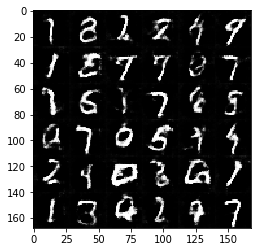

Epoch 1/2... Batch 510... Discriminator Loss: 1.2599... Generator Loss: 0.7134
Epoch 1/2... Batch 520... Discriminator Loss: 1.1867... Generator Loss: 1.1340
Epoch 1/2... Batch 530... Discriminator Loss: 1.1771... Generator Loss: 0.7986
Epoch 1/2... Batch 540... Discriminator Loss: 1.2658... Generator Loss: 0.6229
Epoch 1/2... Batch 550... Discriminator Loss: 1.1181... Generator Loss: 1.3524
Epoch 1/2... Batch 560... Discriminator Loss: 1.1888... Generator Loss: 0.9077
Epoch 1/2... Batch 570... Discriminator Loss: 1.3396... Generator Loss: 0.5437
Epoch 1/2... Batch 580... Discriminator Loss: 1.1262... Generator Loss: 0.8994
Epoch 1/2... Batch 590... Discriminator Loss: 1.1460... Generator Loss: 1.5031
Epoch 1/2... Batch 600... Discriminator Loss: 1.7005... Generator Loss: 0.3558


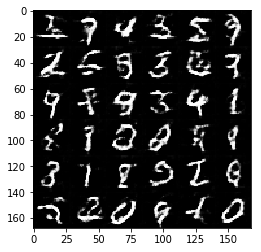

Epoch 1/2... Batch 610... Discriminator Loss: 1.0686... Generator Loss: 0.8501
Epoch 1/2... Batch 620... Discriminator Loss: 1.8861... Generator Loss: 0.3076
Epoch 1/2... Batch 630... Discriminator Loss: 1.3138... Generator Loss: 0.5460
Epoch 1/2... Batch 640... Discriminator Loss: 1.1842... Generator Loss: 0.8349
Epoch 1/2... Batch 650... Discriminator Loss: 1.9717... Generator Loss: 0.2472
Epoch 1/2... Batch 660... Discriminator Loss: 1.2189... Generator Loss: 0.7044
Epoch 1/2... Batch 670... Discriminator Loss: 1.1287... Generator Loss: 0.8555
Epoch 1/2... Batch 680... Discriminator Loss: 1.3410... Generator Loss: 0.5476
Epoch 1/2... Batch 690... Discriminator Loss: 0.9020... Generator Loss: 1.3178
Epoch 1/2... Batch 700... Discriminator Loss: 1.2104... Generator Loss: 0.6752


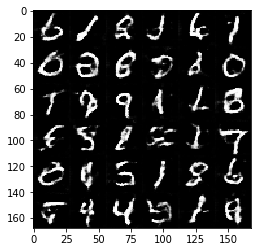

Epoch 1/2... Batch 710... Discriminator Loss: 1.1042... Generator Loss: 0.9098
Epoch 1/2... Batch 720... Discriminator Loss: 1.0481... Generator Loss: 1.0987
Epoch 1/2... Batch 730... Discriminator Loss: 1.4013... Generator Loss: 0.5047
Epoch 1/2... Batch 740... Discriminator Loss: 2.0856... Generator Loss: 2.5325
Epoch 1/2... Batch 750... Discriminator Loss: 1.1577... Generator Loss: 1.0192
Epoch 1/2... Batch 760... Discriminator Loss: 1.2148... Generator Loss: 0.7711
Epoch 1/2... Batch 770... Discriminator Loss: 1.2757... Generator Loss: 0.6601
Epoch 1/2... Batch 780... Discriminator Loss: 0.9529... Generator Loss: 1.0515
Epoch 1/2... Batch 790... Discriminator Loss: 1.1191... Generator Loss: 0.8016
Epoch 1/2... Batch 800... Discriminator Loss: 1.1038... Generator Loss: 1.4680


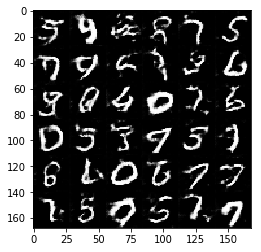

Epoch 1/2... Batch 810... Discriminator Loss: 1.5883... Generator Loss: 0.4151
Epoch 1/2... Batch 820... Discriminator Loss: 1.0257... Generator Loss: 1.3380
Epoch 1/2... Batch 830... Discriminator Loss: 1.1899... Generator Loss: 0.7431
Epoch 1/2... Batch 840... Discriminator Loss: 1.1970... Generator Loss: 1.2383
Epoch 1/2... Batch 850... Discriminator Loss: 1.0527... Generator Loss: 1.3211
Epoch 1/2... Batch 860... Discriminator Loss: 1.0428... Generator Loss: 0.8990
Epoch 1/2... Batch 870... Discriminator Loss: 1.0226... Generator Loss: 1.6439
Epoch 1/2... Batch 880... Discriminator Loss: 1.2545... Generator Loss: 1.3141
Epoch 1/2... Batch 890... Discriminator Loss: 1.2430... Generator Loss: 0.6435
Epoch 1/2... Batch 900... Discriminator Loss: 0.9870... Generator Loss: 0.9978


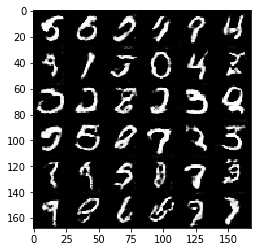

Epoch 1/2... Batch 910... Discriminator Loss: 0.9555... Generator Loss: 1.0609
Epoch 1/2... Batch 920... Discriminator Loss: 1.3408... Generator Loss: 0.6038
Epoch 1/2... Batch 930... Discriminator Loss: 1.2473... Generator Loss: 0.6567
Epoch 1/2... Batch 940... Discriminator Loss: 1.5917... Generator Loss: 0.5376
Epoch 1/2... Batch 950... Discriminator Loss: 1.0009... Generator Loss: 1.9252
Epoch 1/2... Batch 960... Discriminator Loss: 1.2167... Generator Loss: 0.7007
Epoch 1/2... Batch 970... Discriminator Loss: 1.0309... Generator Loss: 0.9899
Epoch 1/2... Batch 980... Discriminator Loss: 1.0433... Generator Loss: 0.9709
Epoch 1/2... Batch 990... Discriminator Loss: 1.1498... Generator Loss: 0.7567
Epoch 1/2... Batch 1000... Discriminator Loss: 1.0098... Generator Loss: 1.0084


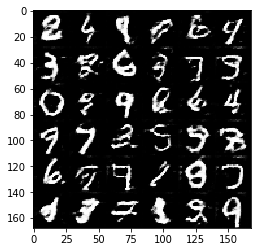

Epoch 1/2... Batch 1010... Discriminator Loss: 1.1842... Generator Loss: 0.7351
Epoch 1/2... Batch 1020... Discriminator Loss: 1.4430... Generator Loss: 0.4980
Epoch 1/2... Batch 1030... Discriminator Loss: 1.4379... Generator Loss: 0.4969
Epoch 1/2... Batch 1040... Discriminator Loss: 1.2546... Generator Loss: 0.7448
Epoch 1/2... Batch 1050... Discriminator Loss: 1.1712... Generator Loss: 0.7778
Epoch 1/2... Batch 1060... Discriminator Loss: 1.3360... Generator Loss: 0.5666
Epoch 1/2... Batch 1070... Discriminator Loss: 1.0796... Generator Loss: 0.7507
Epoch 1/2... Batch 1080... Discriminator Loss: 0.8968... Generator Loss: 1.2588
Epoch 1/2... Batch 1090... Discriminator Loss: 0.9129... Generator Loss: 1.8496
Epoch 1/2... Batch 1100... Discriminator Loss: 1.2177... Generator Loss: 0.9730


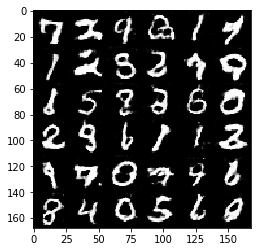

Epoch 1/2... Batch 1110... Discriminator Loss: 1.5461... Generator Loss: 2.7290
Epoch 1/2... Batch 1120... Discriminator Loss: 0.8260... Generator Loss: 1.2436
Epoch 1/2... Batch 1130... Discriminator Loss: 1.0113... Generator Loss: 0.9560
Epoch 1/2... Batch 1140... Discriminator Loss: 1.0181... Generator Loss: 1.6748
Epoch 1/2... Batch 1150... Discriminator Loss: 1.3825... Generator Loss: 0.5957
Epoch 1/2... Batch 1160... Discriminator Loss: 0.9443... Generator Loss: 1.0280
Epoch 1/2... Batch 1170... Discriminator Loss: 1.0362... Generator Loss: 1.0403
Epoch 1/2... Batch 1180... Discriminator Loss: 1.2342... Generator Loss: 0.6678
Epoch 1/2... Batch 1190... Discriminator Loss: 0.9941... Generator Loss: 1.4707
Epoch 1/2... Batch 1200... Discriminator Loss: 1.3069... Generator Loss: 0.5831


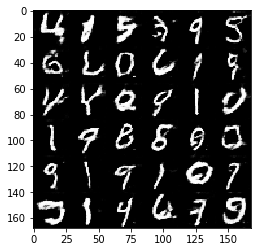

Epoch 1/2... Batch 1210... Discriminator Loss: 1.0811... Generator Loss: 0.8008
Epoch 1/2... Batch 1220... Discriminator Loss: 0.9206... Generator Loss: 1.8321
Epoch 1/2... Batch 1230... Discriminator Loss: 0.8246... Generator Loss: 1.6125
Epoch 1/2... Batch 1240... Discriminator Loss: 0.8184... Generator Loss: 1.3776
Epoch 1/2... Batch 1250... Discriminator Loss: 1.2198... Generator Loss: 0.6749
Epoch 1/2... Batch 1260... Discriminator Loss: 1.1720... Generator Loss: 0.6636
Epoch 1/2... Batch 1270... Discriminator Loss: 1.0389... Generator Loss: 0.9525
Epoch 1/2... Batch 1280... Discriminator Loss: 0.8954... Generator Loss: 1.0621
Epoch 1/2... Batch 1290... Discriminator Loss: 1.0471... Generator Loss: 0.8013
Epoch 1/2... Batch 1300... Discriminator Loss: 1.3865... Generator Loss: 1.8856


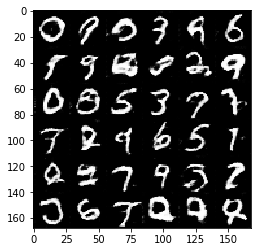

Epoch 1/2... Batch 1310... Discriminator Loss: 1.3652... Generator Loss: 0.5919
Epoch 1/2... Batch 1320... Discriminator Loss: 1.0653... Generator Loss: 0.8094
Epoch 1/2... Batch 1330... Discriminator Loss: 0.8832... Generator Loss: 1.1892
Epoch 1/2... Batch 1340... Discriminator Loss: 1.4621... Generator Loss: 0.4667
Epoch 1/2... Batch 1350... Discriminator Loss: 1.0310... Generator Loss: 1.4422
Epoch 1/2... Batch 1360... Discriminator Loss: 0.8804... Generator Loss: 1.0692
Epoch 1/2... Batch 1370... Discriminator Loss: 0.9614... Generator Loss: 1.0508
Epoch 1/2... Batch 1380... Discriminator Loss: 2.1393... Generator Loss: 0.2394
Epoch 1/2... Batch 1390... Discriminator Loss: 1.0459... Generator Loss: 0.8474
Epoch 1/2... Batch 1400... Discriminator Loss: 1.7617... Generator Loss: 0.3762


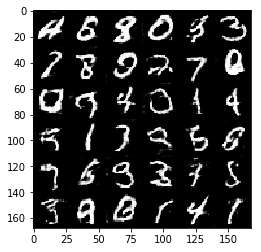

Epoch 1/2... Batch 1410... Discriminator Loss: 1.1397... Generator Loss: 0.7073
Epoch 1/2... Batch 1420... Discriminator Loss: 0.8335... Generator Loss: 1.1047
Epoch 1/2... Batch 1430... Discriminator Loss: 0.9140... Generator Loss: 1.1776
Epoch 1/2... Batch 1440... Discriminator Loss: 1.4059... Generator Loss: 0.5884
Epoch 1/2... Batch 1450... Discriminator Loss: 0.8910... Generator Loss: 1.1428
Epoch 1/2... Batch 1460... Discriminator Loss: 0.9038... Generator Loss: 1.2241
Epoch 1/2... Batch 1470... Discriminator Loss: 1.1760... Generator Loss: 0.7896
Epoch 1/2... Batch 1480... Discriminator Loss: 0.7720... Generator Loss: 1.8238
Epoch 1/2... Batch 1490... Discriminator Loss: 0.9936... Generator Loss: 0.9575
Epoch 1/2... Batch 1500... Discriminator Loss: 1.4816... Generator Loss: 2.4664


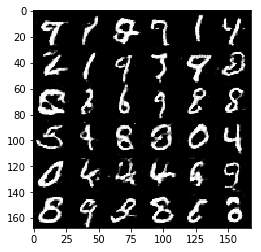

Epoch 1/2... Batch 1510... Discriminator Loss: 1.1773... Generator Loss: 0.7568
Epoch 1/2... Batch 1520... Discriminator Loss: 0.9330... Generator Loss: 1.1332
Epoch 1/2... Batch 1530... Discriminator Loss: 1.1028... Generator Loss: 0.8155
Epoch 1/2... Batch 1540... Discriminator Loss: 1.5025... Generator Loss: 0.4848
Epoch 1/2... Batch 1550... Discriminator Loss: 1.6880... Generator Loss: 0.4194
Epoch 1/2... Batch 1560... Discriminator Loss: 1.9018... Generator Loss: 3.0733
Epoch 1/2... Batch 1570... Discriminator Loss: 0.9049... Generator Loss: 1.0497
Epoch 1/2... Batch 1580... Discriminator Loss: 1.1317... Generator Loss: 0.7322
Epoch 1/2... Batch 1590... Discriminator Loss: 1.1329... Generator Loss: 0.7483
Epoch 1/2... Batch 1600... Discriminator Loss: 1.3102... Generator Loss: 0.5627


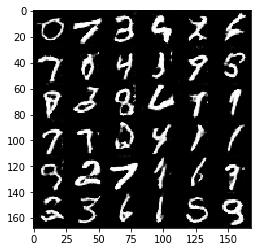

Epoch 1/2... Batch 1610... Discriminator Loss: 0.9069... Generator Loss: 1.2027
Epoch 1/2... Batch 1620... Discriminator Loss: 0.7626... Generator Loss: 2.2862
Epoch 1/2... Batch 1630... Discriminator Loss: 0.9348... Generator Loss: 1.1860
Epoch 1/2... Batch 1640... Discriminator Loss: 0.8573... Generator Loss: 1.1721
Epoch 1/2... Batch 1650... Discriminator Loss: 1.2661... Generator Loss: 0.6557
Epoch 1/2... Batch 1660... Discriminator Loss: 0.9764... Generator Loss: 0.9681
Epoch 1/2... Batch 1670... Discriminator Loss: 0.7715... Generator Loss: 1.3202
Epoch 1/2... Batch 1680... Discriminator Loss: 1.2975... Generator Loss: 0.6890
Epoch 1/2... Batch 1690... Discriminator Loss: 1.1297... Generator Loss: 0.7432
Epoch 1/2... Batch 1700... Discriminator Loss: 1.1251... Generator Loss: 0.8080


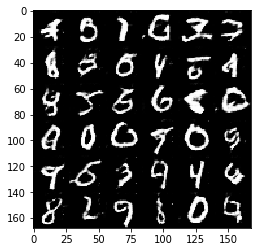

Epoch 1/2... Batch 1710... Discriminator Loss: 1.0152... Generator Loss: 1.6532
Epoch 1/2... Batch 1720... Discriminator Loss: 0.9200... Generator Loss: 1.5289
Epoch 1/2... Batch 1730... Discriminator Loss: 1.0058... Generator Loss: 0.8916
Epoch 1/2... Batch 1740... Discriminator Loss: 0.9350... Generator Loss: 1.9427
Epoch 1/2... Batch 1750... Discriminator Loss: 0.8749... Generator Loss: 1.1738
Epoch 1/2... Batch 1760... Discriminator Loss: 0.8743... Generator Loss: 1.0717
Epoch 1/2... Batch 1770... Discriminator Loss: 0.9826... Generator Loss: 1.0182
Epoch 1/2... Batch 1780... Discriminator Loss: 0.8221... Generator Loss: 1.2016
Epoch 1/2... Batch 1790... Discriminator Loss: 1.1289... Generator Loss: 0.7662
Epoch 1/2... Batch 1800... Discriminator Loss: 1.0930... Generator Loss: 0.8079


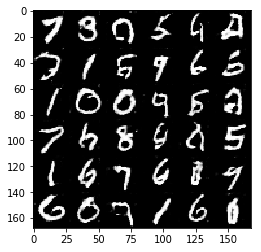

Epoch 1/2... Batch 1810... Discriminator Loss: 1.1743... Generator Loss: 0.6914
Epoch 1/2... Batch 1820... Discriminator Loss: 1.2132... Generator Loss: 2.0358
Epoch 1/2... Batch 1830... Discriminator Loss: 1.4650... Generator Loss: 0.4686
Epoch 1/2... Batch 1840... Discriminator Loss: 0.9726... Generator Loss: 1.2779
Epoch 1/2... Batch 1850... Discriminator Loss: 1.5531... Generator Loss: 0.4762
Epoch 1/2... Batch 1860... Discriminator Loss: 1.1340... Generator Loss: 0.7345
Epoch 1/2... Batch 1870... Discriminator Loss: 1.0414... Generator Loss: 2.2576
Epoch 2/2... Batch 10... Discriminator Loss: 0.9086... Generator Loss: 1.0739
Epoch 2/2... Batch 20... Discriminator Loss: 0.8324... Generator Loss: 1.3944
Epoch 2/2... Batch 30... Discriminator Loss: 0.8886... Generator Loss: 2.0281
Epoch 2/2... Batch 40... Discriminator Loss: 1.5104... Generator Loss: 0.5049
Epoch 2/2... Batch 50... Discriminator Loss: 0.7810... Generator Loss: 1.2819
Epoch 2/2... Batch 60... Discriminator Loss: 0.962

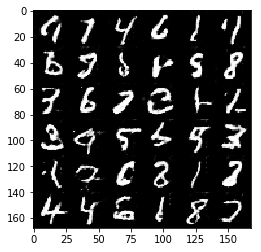

Epoch 2/2... Batch 110... Discriminator Loss: 1.5719... Generator Loss: 0.4588
Epoch 2/2... Batch 120... Discriminator Loss: 0.8427... Generator Loss: 1.1740
Epoch 2/2... Batch 130... Discriminator Loss: 1.0543... Generator Loss: 0.8124
Epoch 2/2... Batch 140... Discriminator Loss: 1.1027... Generator Loss: 0.7698
Epoch 2/2... Batch 150... Discriminator Loss: 0.6815... Generator Loss: 1.5652
Epoch 2/2... Batch 160... Discriminator Loss: 0.9384... Generator Loss: 1.0722
Epoch 2/2... Batch 170... Discriminator Loss: 0.8017... Generator Loss: 1.3113
Epoch 2/2... Batch 180... Discriminator Loss: 2.0309... Generator Loss: 3.9262
Epoch 2/2... Batch 190... Discriminator Loss: 0.9598... Generator Loss: 1.0550
Epoch 2/2... Batch 200... Discriminator Loss: 0.9758... Generator Loss: 1.2278


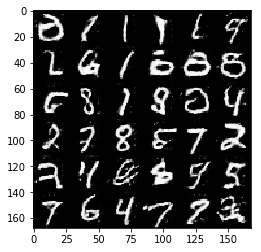

Epoch 2/2... Batch 210... Discriminator Loss: 0.8658... Generator Loss: 1.0795
Epoch 2/2... Batch 220... Discriminator Loss: 0.8527... Generator Loss: 1.1828
Epoch 2/2... Batch 230... Discriminator Loss: 1.0046... Generator Loss: 0.9281
Epoch 2/2... Batch 240... Discriminator Loss: 0.7655... Generator Loss: 1.4524
Epoch 2/2... Batch 250... Discriminator Loss: 1.0954... Generator Loss: 1.3256
Epoch 2/2... Batch 260... Discriminator Loss: 1.0264... Generator Loss: 0.8494
Epoch 2/2... Batch 270... Discriminator Loss: 0.7322... Generator Loss: 1.3119
Epoch 2/2... Batch 280... Discriminator Loss: 0.9786... Generator Loss: 1.6439
Epoch 2/2... Batch 290... Discriminator Loss: 0.7299... Generator Loss: 1.3976
Epoch 2/2... Batch 300... Discriminator Loss: 0.9672... Generator Loss: 1.1829


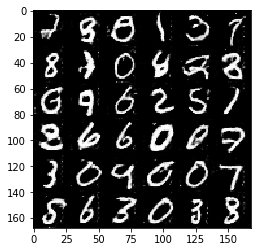

Epoch 2/2... Batch 310... Discriminator Loss: 0.7771... Generator Loss: 1.3996
Epoch 2/2... Batch 320... Discriminator Loss: 0.8004... Generator Loss: 1.3523
Epoch 2/2... Batch 330... Discriminator Loss: 1.0002... Generator Loss: 2.9954
Epoch 2/2... Batch 340... Discriminator Loss: 1.1262... Generator Loss: 0.7665
Epoch 2/2... Batch 350... Discriminator Loss: 0.7742... Generator Loss: 1.2761
Epoch 2/2... Batch 360... Discriminator Loss: 1.5672... Generator Loss: 0.4662
Epoch 2/2... Batch 370... Discriminator Loss: 1.8158... Generator Loss: 0.4965
Epoch 2/2... Batch 380... Discriminator Loss: 0.8495... Generator Loss: 1.3719
Epoch 2/2... Batch 390... Discriminator Loss: 1.1815... Generator Loss: 0.7403
Epoch 2/2... Batch 400... Discriminator Loss: 0.7489... Generator Loss: 1.3730


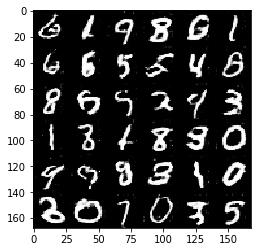

Epoch 2/2... Batch 410... Discriminator Loss: 0.9683... Generator Loss: 1.0555
Epoch 2/2... Batch 420... Discriminator Loss: 0.7588... Generator Loss: 1.4111
Epoch 2/2... Batch 430... Discriminator Loss: 0.7828... Generator Loss: 1.3879
Epoch 2/2... Batch 440... Discriminator Loss: 0.9618... Generator Loss: 2.8713
Epoch 2/2... Batch 450... Discriminator Loss: 0.9222... Generator Loss: 1.8113
Epoch 2/2... Batch 460... Discriminator Loss: 0.8832... Generator Loss: 1.2035
Epoch 2/2... Batch 470... Discriminator Loss: 0.7634... Generator Loss: 1.3333
Epoch 2/2... Batch 480... Discriminator Loss: 0.8365... Generator Loss: 1.2338
Epoch 2/2... Batch 490... Discriminator Loss: 1.4149... Generator Loss: 0.5263
Epoch 2/2... Batch 500... Discriminator Loss: 0.6620... Generator Loss: 1.6583


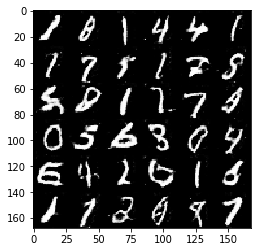

Epoch 2/2... Batch 510... Discriminator Loss: 0.6550... Generator Loss: 1.6944
Epoch 2/2... Batch 520... Discriminator Loss: 1.1729... Generator Loss: 0.7132
Epoch 2/2... Batch 530... Discriminator Loss: 0.8747... Generator Loss: 1.0701
Epoch 2/2... Batch 540... Discriminator Loss: 0.9228... Generator Loss: 1.0922
Epoch 2/2... Batch 550... Discriminator Loss: 0.6164... Generator Loss: 1.6905
Epoch 2/2... Batch 560... Discriminator Loss: 1.0998... Generator Loss: 0.7926
Epoch 2/2... Batch 570... Discriminator Loss: 0.7432... Generator Loss: 1.4732
Epoch 2/2... Batch 580... Discriminator Loss: 0.5561... Generator Loss: 2.0447
Epoch 2/2... Batch 590... Discriminator Loss: 0.8267... Generator Loss: 1.1922
Epoch 2/2... Batch 600... Discriminator Loss: 0.6763... Generator Loss: 1.6655


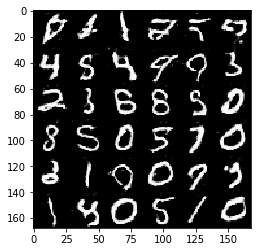

Epoch 2/2... Batch 610... Discriminator Loss: 0.8070... Generator Loss: 1.1765
Epoch 2/2... Batch 620... Discriminator Loss: 0.8415... Generator Loss: 1.0854
Epoch 2/2... Batch 630... Discriminator Loss: 0.6960... Generator Loss: 1.4862
Epoch 2/2... Batch 640... Discriminator Loss: 0.8934... Generator Loss: 1.1161
Epoch 2/2... Batch 650... Discriminator Loss: 0.9781... Generator Loss: 0.9403
Epoch 2/2... Batch 660... Discriminator Loss: 0.7916... Generator Loss: 2.2554
Epoch 2/2... Batch 670... Discriminator Loss: 0.6973... Generator Loss: 1.5898
Epoch 2/2... Batch 680... Discriminator Loss: 1.6613... Generator Loss: 0.4799
Epoch 2/2... Batch 690... Discriminator Loss: 0.7655... Generator Loss: 1.3908
Epoch 2/2... Batch 700... Discriminator Loss: 0.7365... Generator Loss: 2.2624


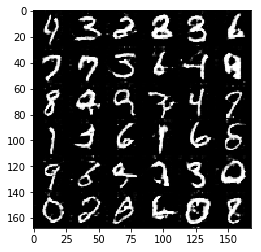

Epoch 2/2... Batch 710... Discriminator Loss: 1.0923... Generator Loss: 0.8622
Epoch 2/2... Batch 720... Discriminator Loss: 0.7759... Generator Loss: 1.8494
Epoch 2/2... Batch 730... Discriminator Loss: 0.7350... Generator Loss: 1.3262
Epoch 2/2... Batch 740... Discriminator Loss: 0.8680... Generator Loss: 1.1694
Epoch 2/2... Batch 750... Discriminator Loss: 1.0011... Generator Loss: 2.6208
Epoch 2/2... Batch 760... Discriminator Loss: 1.4726... Generator Loss: 0.6964
Epoch 2/2... Batch 770... Discriminator Loss: 1.4846... Generator Loss: 0.5163
Epoch 2/2... Batch 780... Discriminator Loss: 0.7562... Generator Loss: 1.3693
Epoch 2/2... Batch 790... Discriminator Loss: 0.7999... Generator Loss: 1.1843
Epoch 2/2... Batch 800... Discriminator Loss: 0.8083... Generator Loss: 1.1909


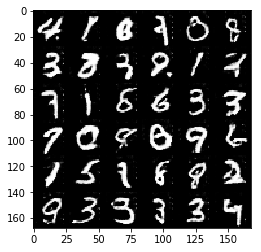

Epoch 2/2... Batch 810... Discriminator Loss: 1.2175... Generator Loss: 0.6748
Epoch 2/2... Batch 820... Discriminator Loss: 0.8353... Generator Loss: 1.5650
Epoch 2/2... Batch 830... Discriminator Loss: 1.4157... Generator Loss: 0.5747
Epoch 2/2... Batch 840... Discriminator Loss: 0.9088... Generator Loss: 1.0293
Epoch 2/2... Batch 850... Discriminator Loss: 0.8350... Generator Loss: 1.1686
Epoch 2/2... Batch 860... Discriminator Loss: 0.9354... Generator Loss: 1.0570
Epoch 2/2... Batch 870... Discriminator Loss: 0.6774... Generator Loss: 1.5737
Epoch 2/2... Batch 880... Discriminator Loss: 0.7250... Generator Loss: 1.5327
Epoch 2/2... Batch 890... Discriminator Loss: 1.3258... Generator Loss: 0.6735
Epoch 2/2... Batch 900... Discriminator Loss: 0.7581... Generator Loss: 1.3516


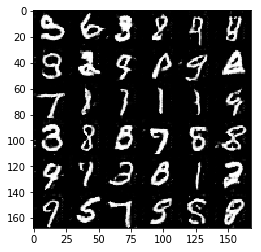

Epoch 2/2... Batch 910... Discriminator Loss: 1.4846... Generator Loss: 0.5389
Epoch 2/2... Batch 920... Discriminator Loss: 1.5462... Generator Loss: 0.4332
Epoch 2/2... Batch 930... Discriminator Loss: 1.8351... Generator Loss: 0.4132
Epoch 2/2... Batch 940... Discriminator Loss: 0.7251... Generator Loss: 1.4234
Epoch 2/2... Batch 950... Discriminator Loss: 0.8253... Generator Loss: 1.1493
Epoch 2/2... Batch 960... Discriminator Loss: 1.1825... Generator Loss: 0.6964
Epoch 2/2... Batch 970... Discriminator Loss: 0.8823... Generator Loss: 1.0881
Epoch 2/2... Batch 980... Discriminator Loss: 0.6297... Generator Loss: 1.7547
Epoch 2/2... Batch 990... Discriminator Loss: 0.7742... Generator Loss: 2.6616
Epoch 2/2... Batch 1000... Discriminator Loss: 0.8076... Generator Loss: 1.2485


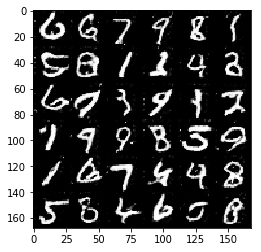

Epoch 2/2... Batch 1010... Discriminator Loss: 0.5716... Generator Loss: 2.1834
Epoch 2/2... Batch 1020... Discriminator Loss: 0.8954... Generator Loss: 1.0734
Epoch 2/2... Batch 1030... Discriminator Loss: 0.6052... Generator Loss: 1.7025
Epoch 2/2... Batch 1040... Discriminator Loss: 1.1470... Generator Loss: 0.8936
Epoch 2/2... Batch 1050... Discriminator Loss: 0.7894... Generator Loss: 1.2851
Epoch 2/2... Batch 1060... Discriminator Loss: 1.3340... Generator Loss: 0.6573
Epoch 2/2... Batch 1070... Discriminator Loss: 0.7318... Generator Loss: 1.8475
Epoch 2/2... Batch 1080... Discriminator Loss: 0.8925... Generator Loss: 1.2517
Epoch 2/2... Batch 1090... Discriminator Loss: 0.5930... Generator Loss: 2.0185
Epoch 2/2... Batch 1100... Discriminator Loss: 0.7520... Generator Loss: 1.2640


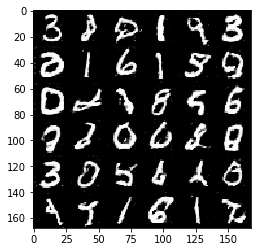

Epoch 2/2... Batch 1110... Discriminator Loss: 1.1033... Generator Loss: 2.7143
Epoch 2/2... Batch 1120... Discriminator Loss: 0.6289... Generator Loss: 1.9919
Epoch 2/2... Batch 1130... Discriminator Loss: 1.0025... Generator Loss: 1.0447
Epoch 2/2... Batch 1140... Discriminator Loss: 0.9254... Generator Loss: 1.1184
Epoch 2/2... Batch 1150... Discriminator Loss: 0.8465... Generator Loss: 1.1954
Epoch 2/2... Batch 1160... Discriminator Loss: 0.8884... Generator Loss: 1.0772
Epoch 2/2... Batch 1170... Discriminator Loss: 1.1114... Generator Loss: 0.8338
Epoch 2/2... Batch 1180... Discriminator Loss: 0.7182... Generator Loss: 1.8416
Epoch 2/2... Batch 1190... Discriminator Loss: 1.8016... Generator Loss: 0.4886
Epoch 2/2... Batch 1200... Discriminator Loss: 0.9076... Generator Loss: 1.1688


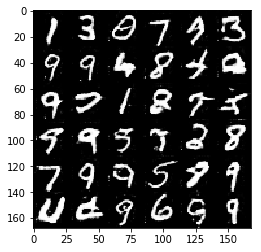

Epoch 2/2... Batch 1210... Discriminator Loss: 1.1345... Generator Loss: 0.8156
Epoch 2/2... Batch 1220... Discriminator Loss: 1.1369... Generator Loss: 0.7832
Epoch 2/2... Batch 1230... Discriminator Loss: 0.5888... Generator Loss: 1.7994
Epoch 2/2... Batch 1240... Discriminator Loss: 0.7360... Generator Loss: 1.3954
Epoch 2/2... Batch 1250... Discriminator Loss: 2.0500... Generator Loss: 0.2624
Epoch 2/2... Batch 1260... Discriminator Loss: 1.2731... Generator Loss: 0.7289
Epoch 2/2... Batch 1270... Discriminator Loss: 0.9559... Generator Loss: 1.0588
Epoch 2/2... Batch 1280... Discriminator Loss: 1.1251... Generator Loss: 0.7866
Epoch 2/2... Batch 1290... Discriminator Loss: 1.0361... Generator Loss: 0.8507
Epoch 2/2... Batch 1300... Discriminator Loss: 0.7562... Generator Loss: 1.9146


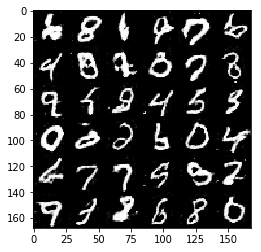

Epoch 2/2... Batch 1310... Discriminator Loss: 0.5130... Generator Loss: 2.1894
Epoch 2/2... Batch 1320... Discriminator Loss: 1.0415... Generator Loss: 1.0722
Epoch 2/2... Batch 1330... Discriminator Loss: 0.4699... Generator Loss: 3.1661
Epoch 2/2... Batch 1340... Discriminator Loss: 0.9738... Generator Loss: 1.1221
Epoch 2/2... Batch 1350... Discriminator Loss: 0.9571... Generator Loss: 1.0429
Epoch 2/2... Batch 1360... Discriminator Loss: 0.9379... Generator Loss: 1.0272
Epoch 2/2... Batch 1370... Discriminator Loss: 1.3428... Generator Loss: 0.6741
Epoch 2/2... Batch 1380... Discriminator Loss: 0.8785... Generator Loss: 1.1850
Epoch 2/2... Batch 1390... Discriminator Loss: 0.6029... Generator Loss: 1.7923
Epoch 2/2... Batch 1400... Discriminator Loss: 0.6187... Generator Loss: 1.7187


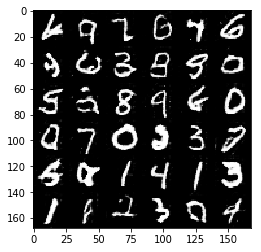

Epoch 2/2... Batch 1410... Discriminator Loss: 0.5887... Generator Loss: 1.9586
Epoch 2/2... Batch 1420... Discriminator Loss: 0.8105... Generator Loss: 1.3579
Epoch 2/2... Batch 1430... Discriminator Loss: 0.6187... Generator Loss: 1.9285
Epoch 2/2... Batch 1440... Discriminator Loss: 2.2082... Generator Loss: 0.2994
Epoch 2/2... Batch 1450... Discriminator Loss: 0.8699... Generator Loss: 1.1678
Epoch 2/2... Batch 1460... Discriminator Loss: 1.0771... Generator Loss: 0.9608
Epoch 2/2... Batch 1470... Discriminator Loss: 0.6750... Generator Loss: 1.5306
Epoch 2/2... Batch 1480... Discriminator Loss: 0.6640... Generator Loss: 2.0465
Epoch 2/2... Batch 1490... Discriminator Loss: 0.5706... Generator Loss: 2.1100
Epoch 2/2... Batch 1500... Discriminator Loss: 0.8689... Generator Loss: 1.1417


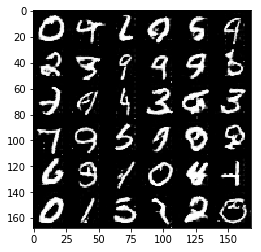

Epoch 2/2... Batch 1510... Discriminator Loss: 0.6752... Generator Loss: 1.4378
Epoch 2/2... Batch 1520... Discriminator Loss: 0.7844... Generator Loss: 1.2356
Epoch 2/2... Batch 1530... Discriminator Loss: 0.7023... Generator Loss: 1.3916
Epoch 2/2... Batch 1540... Discriminator Loss: 2.3150... Generator Loss: 0.3209
Epoch 2/2... Batch 1550... Discriminator Loss: 0.9104... Generator Loss: 1.1204
Epoch 2/2... Batch 1560... Discriminator Loss: 0.8916... Generator Loss: 1.0311
Epoch 2/2... Batch 1570... Discriminator Loss: 0.8782... Generator Loss: 1.0361
Epoch 2/2... Batch 1580... Discriminator Loss: 0.8445... Generator Loss: 2.2475
Epoch 2/2... Batch 1590... Discriminator Loss: 0.9651... Generator Loss: 2.4310
Epoch 2/2... Batch 1600... Discriminator Loss: 1.1788... Generator Loss: 0.7436


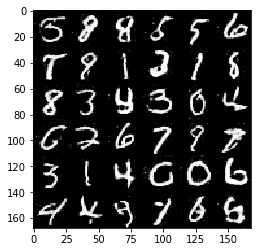

Epoch 2/2... Batch 1610... Discriminator Loss: 0.8372... Generator Loss: 1.1071
Epoch 2/2... Batch 1620... Discriminator Loss: 0.6104... Generator Loss: 1.6588
Epoch 2/2... Batch 1630... Discriminator Loss: 0.9119... Generator Loss: 1.1992
Epoch 2/2... Batch 1640... Discriminator Loss: 0.7888... Generator Loss: 1.2731
Epoch 2/2... Batch 1650... Discriminator Loss: 1.1553... Generator Loss: 4.0679
Epoch 2/2... Batch 1660... Discriminator Loss: 0.7335... Generator Loss: 1.5693
Epoch 2/2... Batch 1670... Discriminator Loss: 0.5725... Generator Loss: 1.9618
Epoch 2/2... Batch 1680... Discriminator Loss: 0.7498... Generator Loss: 1.4997
Epoch 2/2... Batch 1690... Discriminator Loss: 1.1887... Generator Loss: 0.8451
Epoch 2/2... Batch 1700... Discriminator Loss: 0.7284... Generator Loss: 2.5348


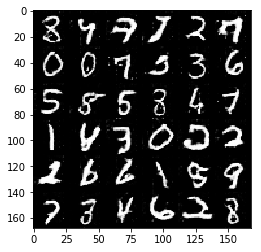

Epoch 2/2... Batch 1710... Discriminator Loss: 0.5486... Generator Loss: 2.1732
Epoch 2/2... Batch 1720... Discriminator Loss: 0.6804... Generator Loss: 1.9402
Epoch 2/2... Batch 1730... Discriminator Loss: 1.0468... Generator Loss: 0.8619
Epoch 2/2... Batch 1740... Discriminator Loss: 0.7446... Generator Loss: 1.4448
Epoch 2/2... Batch 1750... Discriminator Loss: 0.6634... Generator Loss: 2.0179
Epoch 2/2... Batch 1760... Discriminator Loss: 0.7838... Generator Loss: 1.2208
Epoch 2/2... Batch 1770... Discriminator Loss: 0.9651... Generator Loss: 1.0369
Epoch 2/2... Batch 1780... Discriminator Loss: 0.8847... Generator Loss: 1.0127
Epoch 2/2... Batch 1790... Discriminator Loss: 1.0495... Generator Loss: 0.8451
Epoch 2/2... Batch 1800... Discriminator Loss: 2.4256... Generator Loss: 0.2264


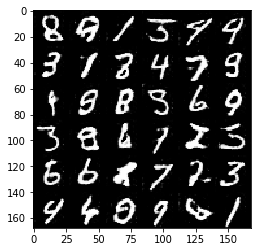

Epoch 2/2... Batch 1810... Discriminator Loss: 0.8422... Generator Loss: 1.1166
Epoch 2/2... Batch 1820... Discriminator Loss: 0.8141... Generator Loss: 1.5923
Epoch 2/2... Batch 1830... Discriminator Loss: 0.6919... Generator Loss: 1.9057
Epoch 2/2... Batch 1840... Discriminator Loss: 0.6711... Generator Loss: 1.5566
Epoch 2/2... Batch 1850... Discriminator Loss: 0.6978... Generator Loss: 1.4388
Epoch 2/2... Batch 1860... Discriminator Loss: 0.9011... Generator Loss: 1.0477
Epoch 2/2... Batch 1870... Discriminator Loss: 0.8043... Generator Loss: 2.2906


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.1647... Generator Loss: 1.0097
Epoch 1/1... Batch 20... Discriminator Loss: 2.8208... Generator Loss: 0.1060
Epoch 1/1... Batch 30... Discriminator Loss: 0.8758... Generator Loss: 1.0323
Epoch 1/1... Batch 40... Discriminator Loss: 0.8199... Generator Loss: 1.5278
Epoch 1/1... Batch 50... Discriminator Loss: 0.6571... Generator Loss: 1.8459
Epoch 1/1... Batch 60... Discriminator Loss: 0.4737... Generator Loss: 3.2327
Epoch 1/1... Batch 70... Discriminator Loss: 0.4878... Generator Loss: 3.1853
Epoch 1/1... Batch 80... Discriminator Loss: 0.7191... Generator Loss: 1.6692
Epoch 1/1... Batch 90... Discriminator Loss: 0.8414... Generator Loss: 6.6217
Epoch 1/1... Batch 100... Discriminator Loss: 1.4735... Generator Loss: 0.8701


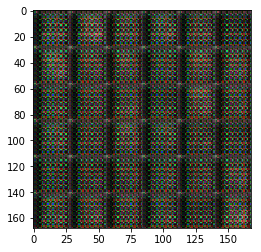

Epoch 1/1... Batch 110... Discriminator Loss: 1.1771... Generator Loss: 0.9021
Epoch 1/1... Batch 120... Discriminator Loss: 0.8793... Generator Loss: 2.2870
Epoch 1/1... Batch 130... Discriminator Loss: 1.2436... Generator Loss: 0.7029
Epoch 1/1... Batch 140... Discriminator Loss: 1.1864... Generator Loss: 0.8382
Epoch 1/1... Batch 150... Discriminator Loss: 1.0293... Generator Loss: 0.9436
Epoch 1/1... Batch 160... Discriminator Loss: 0.7366... Generator Loss: 2.0707
Epoch 1/1... Batch 170... Discriminator Loss: 1.1902... Generator Loss: 0.7308
Epoch 1/1... Batch 180... Discriminator Loss: 0.8369... Generator Loss: 1.4259
Epoch 1/1... Batch 190... Discriminator Loss: 1.2982... Generator Loss: 0.7372
Epoch 1/1... Batch 200... Discriminator Loss: 0.9880... Generator Loss: 1.6855


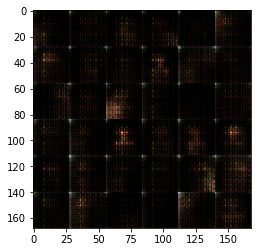

Epoch 1/1... Batch 210... Discriminator Loss: 0.9729... Generator Loss: 1.2285
Epoch 1/1... Batch 220... Discriminator Loss: 1.6404... Generator Loss: 0.6117
Epoch 1/1... Batch 230... Discriminator Loss: 0.9275... Generator Loss: 1.2567
Epoch 1/1... Batch 240... Discriminator Loss: 1.1167... Generator Loss: 1.0722
Epoch 1/1... Batch 250... Discriminator Loss: 1.2933... Generator Loss: 0.6599
Epoch 1/1... Batch 260... Discriminator Loss: 1.4246... Generator Loss: 0.5958
Epoch 1/1... Batch 270... Discriminator Loss: 1.0181... Generator Loss: 1.6857
Epoch 1/1... Batch 280... Discriminator Loss: 1.2627... Generator Loss: 0.8685
Epoch 1/1... Batch 290... Discriminator Loss: 1.0924... Generator Loss: 1.0542
Epoch 1/1... Batch 300... Discriminator Loss: 1.2157... Generator Loss: 1.1534


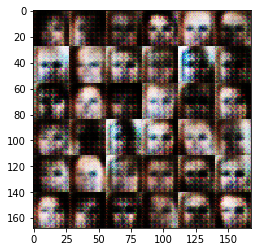

Epoch 1/1... Batch 310... Discriminator Loss: 1.5226... Generator Loss: 0.5060
Epoch 1/1... Batch 320... Discriminator Loss: 1.4225... Generator Loss: 0.6049
Epoch 1/1... Batch 330... Discriminator Loss: 1.5508... Generator Loss: 0.5663
Epoch 1/1... Batch 340... Discriminator Loss: 1.3704... Generator Loss: 0.5858
Epoch 1/1... Batch 350... Discriminator Loss: 1.2522... Generator Loss: 0.9623
Epoch 1/1... Batch 360... Discriminator Loss: 1.3557... Generator Loss: 0.6320
Epoch 1/1... Batch 370... Discriminator Loss: 1.4173... Generator Loss: 0.5740
Epoch 1/1... Batch 380... Discriminator Loss: 1.0764... Generator Loss: 1.0602
Epoch 1/1... Batch 390... Discriminator Loss: 1.3819... Generator Loss: 0.6248
Epoch 1/1... Batch 400... Discriminator Loss: 1.1153... Generator Loss: 1.0588


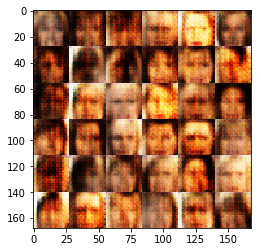

Epoch 1/1... Batch 410... Discriminator Loss: 1.2942... Generator Loss: 1.1261
Epoch 1/1... Batch 420... Discriminator Loss: 1.1041... Generator Loss: 1.1444
Epoch 1/1... Batch 430... Discriminator Loss: 1.5180... Generator Loss: 0.5181
Epoch 1/1... Batch 440... Discriminator Loss: 1.5354... Generator Loss: 0.4775
Epoch 1/1... Batch 450... Discriminator Loss: 1.0657... Generator Loss: 1.1145
Epoch 1/1... Batch 460... Discriminator Loss: 1.2200... Generator Loss: 0.7080
Epoch 1/1... Batch 470... Discriminator Loss: 1.0203... Generator Loss: 0.9754
Epoch 1/1... Batch 480... Discriminator Loss: 1.1885... Generator Loss: 1.5724
Epoch 1/1... Batch 490... Discriminator Loss: 1.4218... Generator Loss: 0.6013
Epoch 1/1... Batch 500... Discriminator Loss: 1.0717... Generator Loss: 1.2865


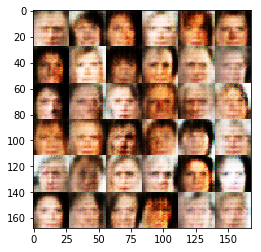

Epoch 1/1... Batch 510... Discriminator Loss: 1.4507... Generator Loss: 0.7865
Epoch 1/1... Batch 520... Discriminator Loss: 1.2929... Generator Loss: 0.9525
Epoch 1/1... Batch 530... Discriminator Loss: 1.1394... Generator Loss: 0.9720
Epoch 1/1... Batch 540... Discriminator Loss: 1.0414... Generator Loss: 1.1110
Epoch 1/1... Batch 550... Discriminator Loss: 1.1098... Generator Loss: 1.1840
Epoch 1/1... Batch 560... Discriminator Loss: 1.1748... Generator Loss: 1.0402
Epoch 1/1... Batch 570... Discriminator Loss: 1.1636... Generator Loss: 0.8222
Epoch 1/1... Batch 580... Discriminator Loss: 1.4472... Generator Loss: 0.4829
Epoch 1/1... Batch 590... Discriminator Loss: 1.1590... Generator Loss: 0.8687
Epoch 1/1... Batch 600... Discriminator Loss: 1.0655... Generator Loss: 1.1792


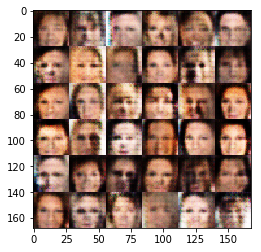

Epoch 1/1... Batch 610... Discriminator Loss: 1.1942... Generator Loss: 0.8694
Epoch 1/1... Batch 620... Discriminator Loss: 1.3709... Generator Loss: 0.5422
Epoch 1/1... Batch 630... Discriminator Loss: 1.0716... Generator Loss: 1.3094
Epoch 1/1... Batch 640... Discriminator Loss: 1.1275... Generator Loss: 1.4941
Epoch 1/1... Batch 650... Discriminator Loss: 1.5059... Generator Loss: 0.6185
Epoch 1/1... Batch 660... Discriminator Loss: 1.2807... Generator Loss: 0.8188
Epoch 1/1... Batch 670... Discriminator Loss: 1.0843... Generator Loss: 1.5301
Epoch 1/1... Batch 680... Discriminator Loss: 0.8634... Generator Loss: 2.1165
Epoch 1/1... Batch 690... Discriminator Loss: 1.7428... Generator Loss: 0.3325
Epoch 1/1... Batch 700... Discriminator Loss: 0.9545... Generator Loss: 2.0550


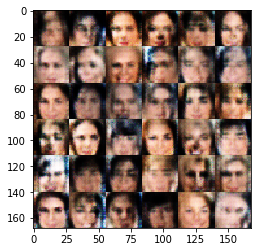

Epoch 1/1... Batch 710... Discriminator Loss: 1.4830... Generator Loss: 3.0719
Epoch 1/1... Batch 720... Discriminator Loss: 0.8740... Generator Loss: 2.0056
Epoch 1/1... Batch 730... Discriminator Loss: 1.2482... Generator Loss: 0.7516
Epoch 1/1... Batch 740... Discriminator Loss: 1.2100... Generator Loss: 0.7270
Epoch 1/1... Batch 750... Discriminator Loss: 1.1491... Generator Loss: 1.1465
Epoch 1/1... Batch 760... Discriminator Loss: 1.0054... Generator Loss: 1.4508
Epoch 1/1... Batch 770... Discriminator Loss: 1.3015... Generator Loss: 0.6366
Epoch 1/1... Batch 780... Discriminator Loss: 1.4039... Generator Loss: 0.6519
Epoch 1/1... Batch 790... Discriminator Loss: 0.8385... Generator Loss: 1.3473
Epoch 1/1... Batch 800... Discriminator Loss: 0.6178... Generator Loss: 1.6442


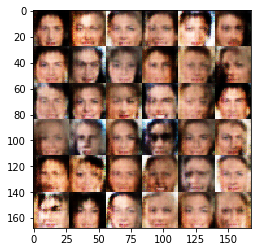

Epoch 1/1... Batch 810... Discriminator Loss: 1.6199... Generator Loss: 0.4201
Epoch 1/1... Batch 820... Discriminator Loss: 1.1130... Generator Loss: 0.9478
Epoch 1/1... Batch 830... Discriminator Loss: 0.9930... Generator Loss: 1.1542
Epoch 1/1... Batch 840... Discriminator Loss: 0.8153... Generator Loss: 1.2584
Epoch 1/1... Batch 850... Discriminator Loss: 1.1520... Generator Loss: 1.5564
Epoch 1/1... Batch 860... Discriminator Loss: 1.0006... Generator Loss: 0.8944
Epoch 1/1... Batch 870... Discriminator Loss: 1.2968... Generator Loss: 0.6097
Epoch 1/1... Batch 880... Discriminator Loss: 1.6320... Generator Loss: 0.3865
Epoch 1/1... Batch 890... Discriminator Loss: 1.5419... Generator Loss: 0.4650
Epoch 1/1... Batch 900... Discriminator Loss: 1.1500... Generator Loss: 1.0169


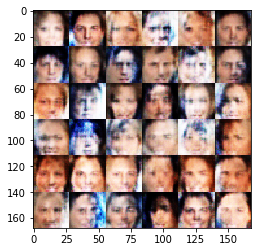

Epoch 1/1... Batch 910... Discriminator Loss: 1.3638... Generator Loss: 0.5819
Epoch 1/1... Batch 920... Discriminator Loss: 0.9831... Generator Loss: 0.9936
Epoch 1/1... Batch 930... Discriminator Loss: 0.8979... Generator Loss: 2.8528
Epoch 1/1... Batch 940... Discriminator Loss: 1.3517... Generator Loss: 0.5233
Epoch 1/1... Batch 950... Discriminator Loss: 2.4378... Generator Loss: 0.1583
Epoch 1/1... Batch 960... Discriminator Loss: 1.6217... Generator Loss: 1.9065
Epoch 1/1... Batch 970... Discriminator Loss: 1.3222... Generator Loss: 1.8474
Epoch 1/1... Batch 980... Discriminator Loss: 1.0766... Generator Loss: 1.0869
Epoch 1/1... Batch 990... Discriminator Loss: 0.7492... Generator Loss: 1.3076
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3190... Generator Loss: 0.7478


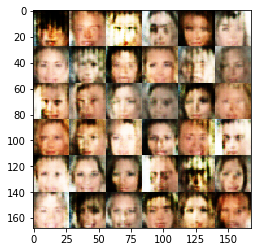

Epoch 1/1... Batch 1010... Discriminator Loss: 0.6123... Generator Loss: 1.6306
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9081... Generator Loss: 0.9868
Epoch 1/1... Batch 1030... Discriminator Loss: 1.9286... Generator Loss: 0.2736
Epoch 1/1... Batch 1040... Discriminator Loss: 0.7462... Generator Loss: 3.2632
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1881... Generator Loss: 0.9488
Epoch 1/1... Batch 1060... Discriminator Loss: 0.9773... Generator Loss: 0.9069
Epoch 1/1... Batch 1070... Discriminator Loss: 0.5129... Generator Loss: 2.2963
Epoch 1/1... Batch 1080... Discriminator Loss: 0.7868... Generator Loss: 1.1269
Epoch 1/1... Batch 1090... Discriminator Loss: 1.1435... Generator Loss: 0.6632
Epoch 1/1... Batch 1100... Discriminator Loss: 0.7527... Generator Loss: 1.5595


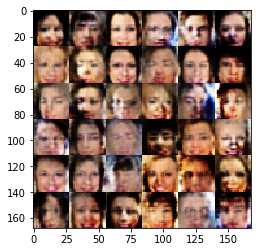

Epoch 1/1... Batch 1110... Discriminator Loss: 1.4606... Generator Loss: 0.4957
Epoch 1/1... Batch 1120... Discriminator Loss: 1.6914... Generator Loss: 0.3322
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3094... Generator Loss: 0.7625
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1947... Generator Loss: 0.8084
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1194... Generator Loss: 1.0716
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1792... Generator Loss: 0.7349
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4754... Generator Loss: 2.6893
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2798... Generator Loss: 0.7479
Epoch 1/1... Batch 1190... Discriminator Loss: 1.2894... Generator Loss: 1.3690
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2463... Generator Loss: 0.6940


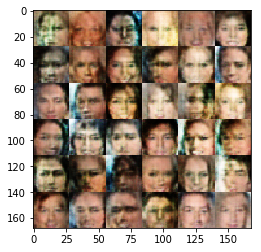

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9888... Generator Loss: 1.6004
Epoch 1/1... Batch 1220... Discriminator Loss: 1.7268... Generator Loss: 0.3438
Epoch 1/1... Batch 1230... Discriminator Loss: 1.1132... Generator Loss: 0.8201


KeyboardInterrupt: 

In [12]:
batch_size = 32
z_dim = 110
learning_rate = 0.00025
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.